In [1]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
import numpy as np

In [2]:
# Take minimum error for all positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

# Returns the convergence count for errors for a set of test parameters
def convergence_counts(errors, parameter, error_threshold = 1e-8):
    zero_error = {}
    for i in range(len(errors)):
        zero_error[parameter[i]] = 0
        for error in errors[i]:
            zero_error[parameter[i]] += error[-1] < error_threshold
    return zero_error

Should spectral initialization happen inside or outside of covariance transform

In [3]:
# Implements BWDG  with thresholding
def bwgd_threshold(y, A, alpha=0, niter = 50):
    d, n = A.shape 
    x = np.zeros((niter, d))  
    threshold = int(alpha * n)

    for iter in range(1, niter):
        # Find indices for smallest |AtX|
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        # Discard the selected indices
        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        # Covariance matrix transform
        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A_filtered

        if iter == 1:
            Y = (1 / n) * (A_tilde @ np.diag(y_filtered) @ A_tilde.T)
            eigenvals, eigenvects = np.linalg.eigh(Y)
            index = np.argmax(eigenvals)  
            x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
            x[0] = C_inv @ x_tilde
                
        # Hessian
        hessian = (A_tilde @ A_tilde.T) / n
        
        # Gradient
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y_filtered) * At_x / (np.abs(At_x)*n))
        x_tilde -= np.linalg.solve(hessian, gradient)

        x[iter] = C_inv @ x_tilde

        if np.linalg.norm(x[iter] - x[iter-1])<1e-15:
                return x[:iter]
        
    return x

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:10<00:00,  1.91s/it]


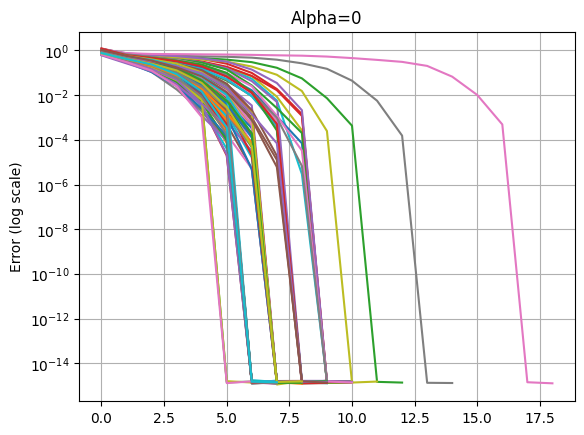

{0: 100}

In [6]:
from tqdm import tqdm
# Plot for d
thresholding = [0]
errors = []

d = 200
n = int(d * np.log(d))

for alpha in thresholding:
    n_error = []
    for j in tqdm(range(1, 101)):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_threshold(y, A,alpha=alpha, niter=20)
        error = min_error(x_hat, x)
        n_error.append(error)
        
        # Plot results
        plt.plot(error)

    errors.append(n_error)
    plt.title(f'Alpha={alpha}')
    plt.ylabel("Error (log scale)")
    plt.yscale('log')  
    plt.grid(True)
    plt.show()
convergence_counts(errors, thresholding)

Sign Agreement experiment

In [101]:
# Function to compute sign agreement percentage for thresholded indices
def sign_agreement(A, x_k, x_star, indices):
    total = len(indices)
    return 100 * np.sum(np.sign(A.T[indices] @ x_k) == np.sign(A.T[indices] @ x_star)) / total

# Implements BWGD with thresholding and tracks sign agreement percentage
def bwgd_threshold_track(y, A, alpha=0, niter=50):
    d, n = A.shape 
    x = np.zeros((niter, d))  
    threshold = int(alpha * n)
    sign_matches = []

    for iter in range(1, niter):
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A_filtered

        if iter == 1:
            Y = (1 / n) * (A_tilde @ np.diag(y_filtered) @ A_tilde.T)
            eigenvals, eigenvects = np.linalg.eigh(Y)
            index = np.argmax(eigenvals)  
            x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
            x[0] = C_inv @ x_tilde
                
        hessian = (A_tilde @ A_tilde.T) / n
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y_filtered) * At_x / (np.abs(At_x) * n))
        h = np.linalg.solve(hessian, gradient)
        x_tilde -= h

        x[iter] = C_inv @ x_tilde

        # Track sign agreement percentage only for thresholded indices
        sign_matches.append(sign_agreement(A, x[iter], x_star, indices))

        if np.linalg.norm(x[iter] - x[iter-1]) < 1e-15:
            return x[:iter], sign_matches
        
    return x, sign_matches

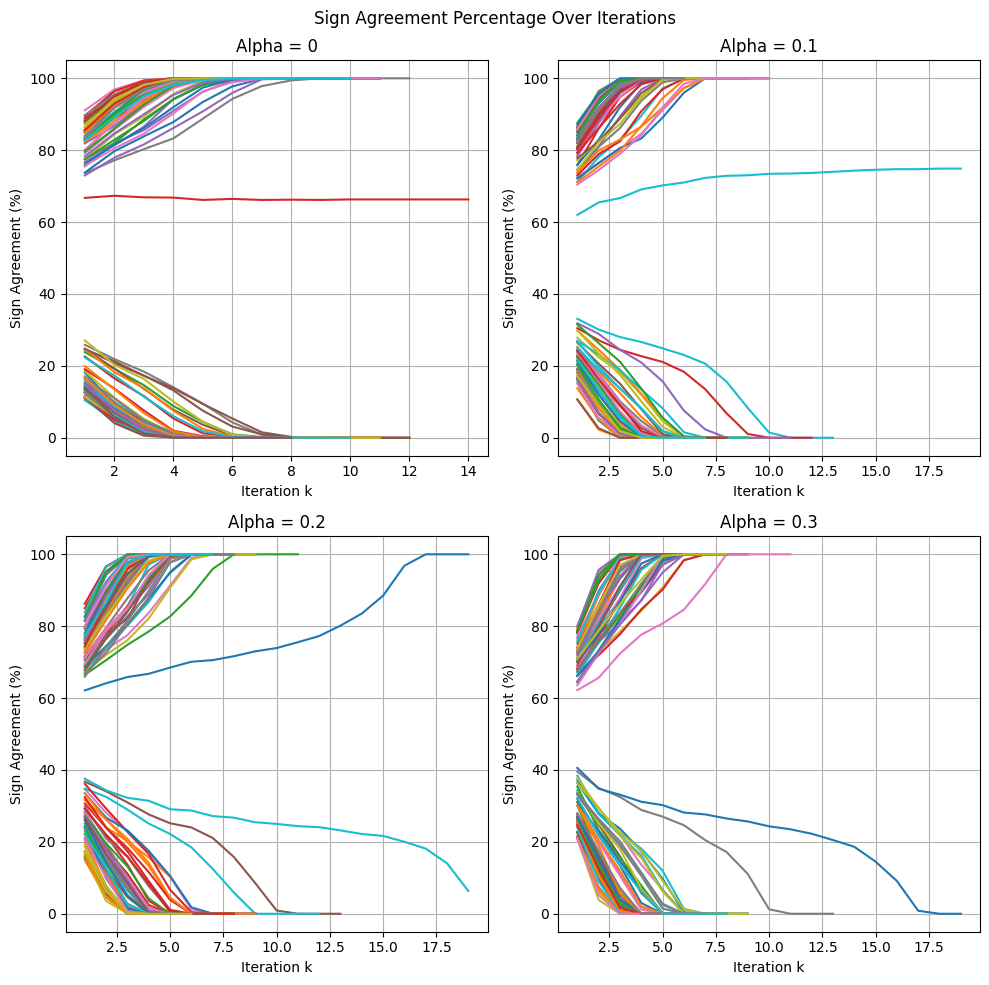

In [102]:
# Experiment parameters
d = 250
n = int(d * np.log(d))
alpha_values = [0, 0.1, 0.2, 0.3]
niter = 20
num_trials = 100

# Create subplots with a square-like grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, alpha in enumerate(alpha_values):
    ax = axes[i]
    
    for _ in range(num_trials):
        x_star = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x_star)

        _, sign_match_counts = bwgd_threshold_track(y, A, alpha=alpha, niter=niter)

        # Plot each trial
        ax.plot(range(1, len(sign_match_counts) + 1), sign_match_counts)

    ax.set_xlabel("Iteration k")
    ax.set_ylabel("Sign Agreement (%)")
    ax.set_title(f"Alpha = {alpha}")
    ax.grid(True)

fig.suptitle("Sign Agreement Percentage Over Iterations")
plt.tight_layout()
plt.show()

Spectral initialization over dimension

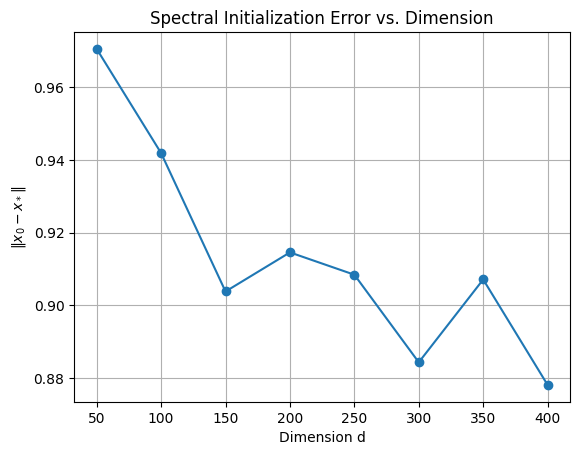

In [103]:
from scipy.linalg import eigh

def spectral_init(A, y):
    d, n = A.shape
    C = (A @ np.diag(y) @ A.T) / n  # Compute spectral matrix
    eigvals, eigvecs = eigh(C)  # Compute eigenvalues and eigenvectors
    index = np.argmax(eigvals)  # Select the largest eigenvector
    x0 = np.sqrt(eigvals[index] / 3) * eigvecs[:, index]  # Scale eigenvector
    return x0

# Compute the minimum error
def min_error_x0(x_hat, x_star):
    error_positive = np.linalg.norm(x_star - x_hat)
    error_negative = np.linalg.norm(-x_star - x_hat)
    return min(error_positive, error_negative)


# Experiment parameters
dimensions = [50, 100, 150, 200, 250, 300, 350, 400]
n_trials = 100  
errors = []

for d in dimensions:
    error_sum = 0
    n = int(d * np.log(d))  # Number of samples

    for _ in range(n_trials):
        x_star = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n) 
        y = np.square(A.T @ x_star)  

        x0 = spectral_init(A, y)  # Perform spectral initialization
        error_sum += min_error_x0(x0, x_star)  # Compute error
    
    avg_error = error_sum / n_trials  # Compute average error
    errors.append(avg_error)  # Store result

# Plot results
plt.plot(dimensions, errors, marker='o', linestyle='-')
plt.xlabel("Dimension d")
plt.ylabel(r"$\|x_0 - x_*\|$")
plt.title("Spectral Initialization Error vs. Dimension")
plt.grid(True)
plt.show()

Distance to leave one out 

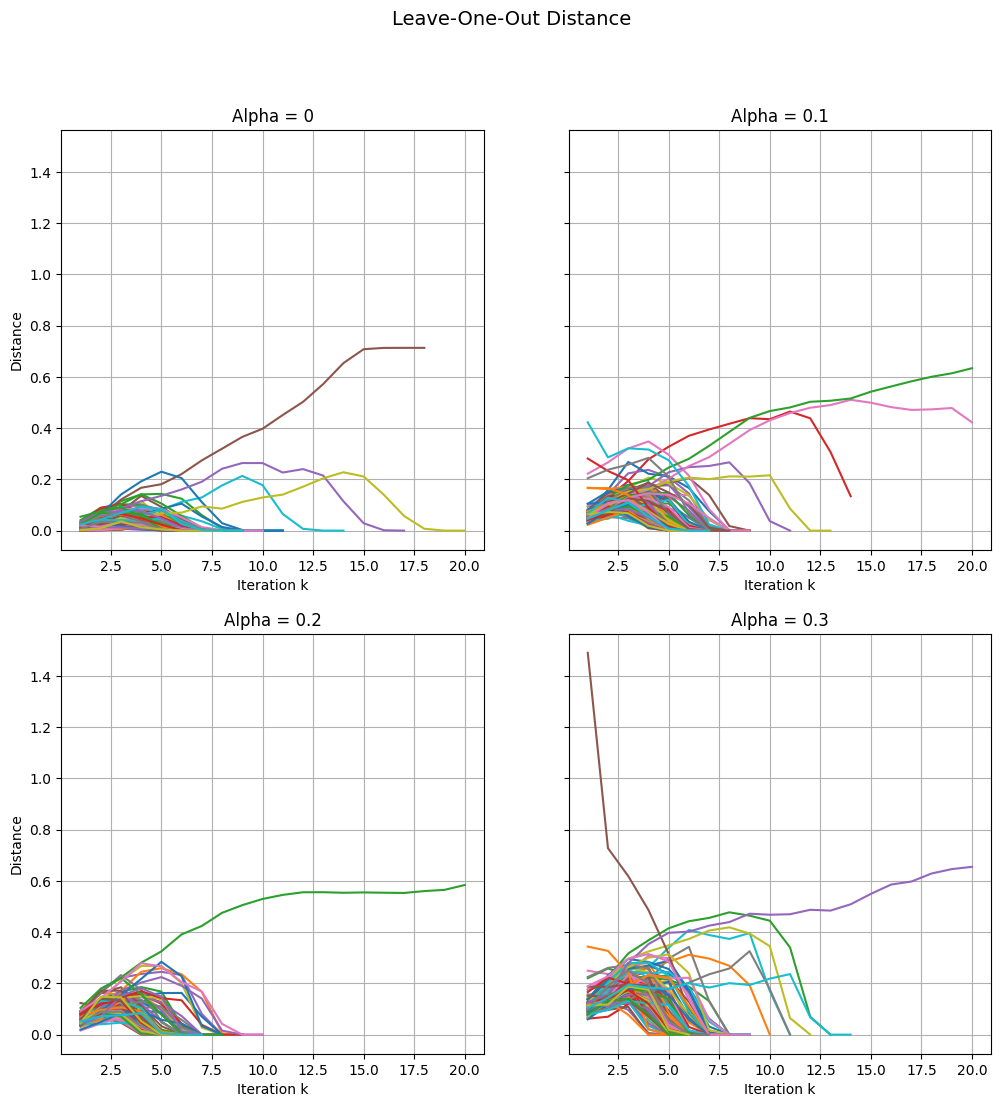

In [104]:
# Compute min distance with sign flip correction
def min_error_l(x_hat, x_star):
    error_positive = np.linalg.norm(x_star - x_hat, axis=1)
    error_negative = np.linalg.norm(-x_star - x_hat, axis=1)
    return np.minimum(error_positive, error_negative)

# Implements BWGD with thresholding
def bwgd_threshold(y, A, alpha=0, niter=20):
    d, n = A.shape 
    x = np.zeros((niter, d))  
    threshold = int(alpha * n)

    for iter in range(1, niter):
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A_filtered

        if iter == 1:
            Y = (1 / n) * (A_tilde @ np.diag(y_filtered) @ A_tilde.T)
            eigenvals, eigenvects = np.linalg.eigh(Y)
            index = np.argmax(eigenvals)  
            x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
            x[0] = C_inv @ x_tilde
                
        hessian = (A_tilde @ A_tilde.T) / n
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y_filtered) * At_x / (np.abs(At_x) * n))
        h = np.linalg.solve(hessian, gradient)
        x_tilde -= h

        x[iter] = C_inv @ x_tilde

        if np.linalg.norm(x[iter] - x[iter-1]) < 1e-15:
            return x[:iter]
        
    return x

# Experiment parameters
d = 250
n = int(d * np.log(d))
alpha_values = [0, 0.1, 0.2, 0.3]
niter = 20
num_trials = 100

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

for i, alpha in enumerate(alpha_values):
    ax = axes[i // 2, i % 2]  # Arrange in a 2x2 grid
    for _ in range(num_trials):
        x_star = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x_star)

        # Run BWGD on full dataset
        x_full = bwgd_threshold(y, A, alpha=alpha, niter=niter)

        # Run BWGD on leave-one-out dataset (remove last column of A)
        A_l = A[:, :-1]
        y_l = np.square(A_l.T @ x_star)
        x_l = bwgd_threshold(y_l, A_l, alpha=alpha, niter=niter)

        # Ensure same iteration count
        T = min(len(x_full), len(x_l))
        x_full_trunc = x_full[:T]
        x_l_trunc = x_l[:T]

        # Compute min-error distance at each iteration
        distances = min_error_l(x_full_trunc, x_l_trunc)

        # Plot each trial
        ax.plot(range(1, len(distances) + 1), distances)

    ax.set_xlabel("Iteration k")
    ax.set_title(f"Alpha = {alpha}")
    ax.grid(True)

# Set a common ylabel for the leftmost plots
axes[0, 0].set_ylabel("Distance")
axes[1, 0].set_ylabel("Distance")

fig.suptitle("Leave-One-Out Distance", fontsize=14)
plt.show()

Iterations to Converge

In [111]:
def bwgd_threshold_convergence(y, A, alpha=0, niter=30, tol=1e-10):
    """Runs BWGD and returns the number of iterations until convergence."""
    d, n = A.shape
    x = np.zeros((niter, d))
    threshold = int(alpha * n)

    for iter in range(1, niter):
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(np.linalg.inv(C_sqrt))
        A_tilde = C_inv @ A_filtered

        if iter == 1:
            Y = (1 / n) * (A_tilde @ np.diag(y_filtered) @ A_tilde.T)
            eigenvals, eigenvects = np.linalg.eigh(Y)
            index = np.argmax(eigenvals)
            x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
            x[0] = C_inv @ x_tilde

        hessian = (A_tilde @ A_tilde.T) / n
        At_x = A_tilde.T @ x_tilde
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y_filtered) * At_x / (np.abs(At_x) * n))
        h = np.linalg.solve(hessian, gradient)
        x_tilde -= h

        x[iter] = C_inv @ x_tilde

        if min_error_x0(x[iter], np.ones(d)/np.sqrt(d)) < tol:
            return iter  # Return number of iterations to convergence

    return niter  # If not converged, return max iterations

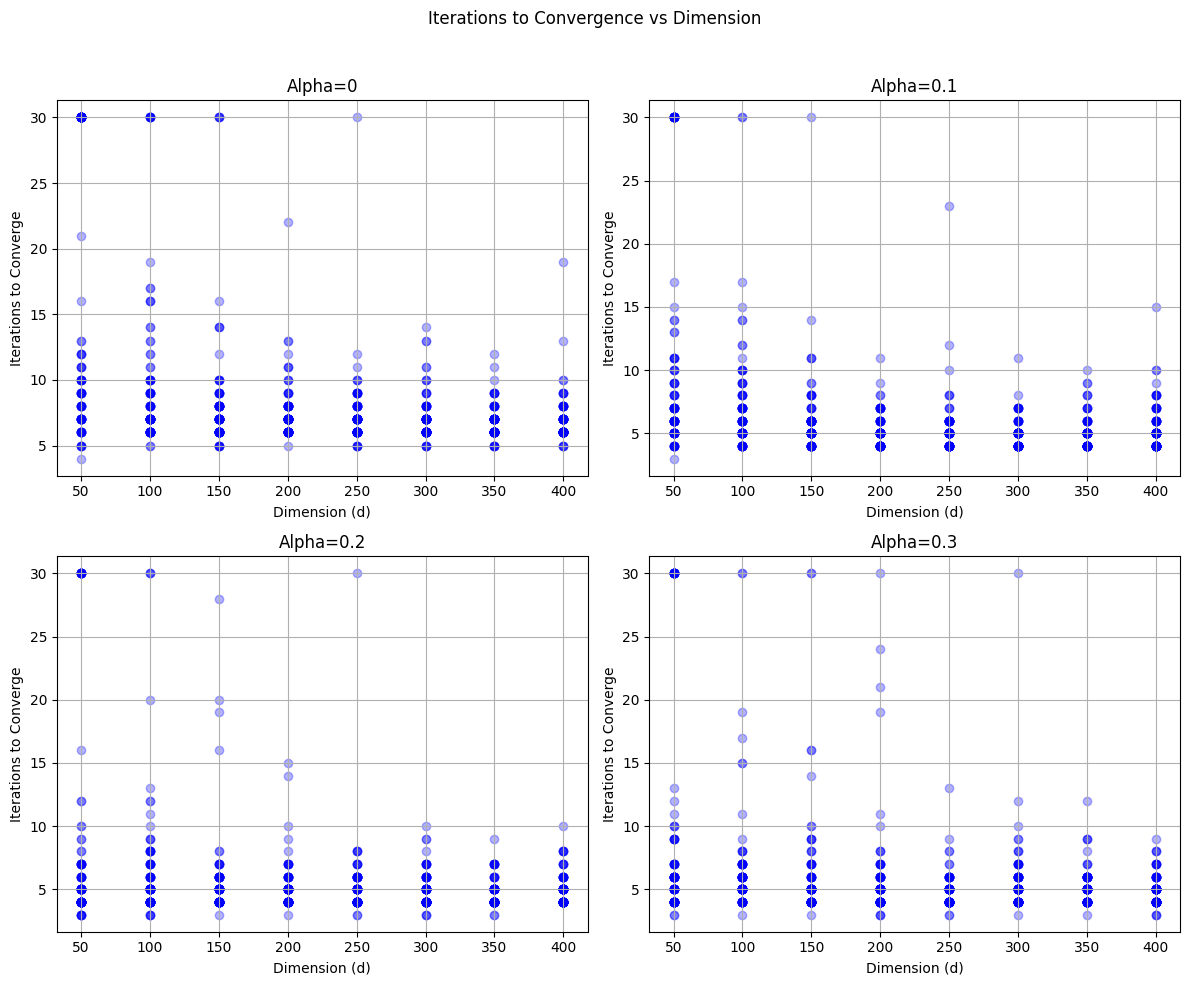

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Experiment parameters
d_values = [50, 100, 150, 200, 250, 300, 350, 400] 
alpha_values = [0, 0.1, 0.2, 0.3]  
niter = 30  # Max iterations
num_trials = 100


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten axes array for easy indexing

for i, alpha in enumerate(alpha_values):
    ax = axes[i]
    
    for d in d_values:
        n = int(d * np.log(d))  # Set n based on dimension

        for _ in range(num_trials):
            x_star = np.ones(d)/np.sqrt(d)
            A = np.random.randn(d, n)
            y = np.square(A.T @ x_star)

            iters = bwgd_threshold_convergence(y, A, alpha=alpha, niter=niter)
            ax.scatter(d, iters, color="blue", alpha=0.3)  # Scatter plot to show individual trials

    ax.set_xlabel("Dimension (d)")
    ax.set_ylabel("Iterations to Converge")
    ax.set_title(f"Alpha={alpha}")
    ax.grid(True)

plt.suptitle("Iterations to Convergence vs Dimension")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
